# Sobol Indices

*Sobol's method* is one of the most popular for global sensitivity analysis. It builds on the [ANOVA decomposition](anova.ipynb).

In [1]:
import tntorch as tn
import torch
import time

N = 20
t = tn.rand([32]*N, ranks_tt=10)
t

20D TT tensor:

 32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10)(11)(12)(13)(14)(15)(16)(17)(18)(19)
 / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
1   10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  1

With *tntorch* we can handle *all* Sobol indices (i.e. for all subsets $\alpha \subseteq \{0, \dots, N-1\}$) at once. We can access and aggregate them using the function `sobol()` and whatever [mask](logic.ipynb) is appropriate.

## Single Variables

### Variance Components

The relative influence (proportion of the overall model variance) attributable to one variable $n$ only, without interactions with others, is known as its *variance component* and denoted as $S_n$. Let's compute it for the first variable $x$:

In [2]:
x, y, z = tn.symbols(N)[:3]
start = time.time()
print(tn.sobol(t, mask=tn.only(x)))
print('This compressed tensor has {} parameters; computing this index took only {:g}s'.format(t.numel(), time.time()-start))

tensor(0.1882)
This compressed tensor has 58240 parameters; computing this index took only 0.0380359s


Input parameters $x, y, \dots$ are assumed independently distributed. By default, uniform marginal distributions are used, but you can specify others with the `marginals` argument (list of vectors). For instance, if the first variable can take one value only, then its sensitivity indices will be 0 (no matter how strong its effect on the multidimensional model is!):

In [3]:
marginals = [None]*N  # By default, None means uniform
marginals[0] = torch.zeros(t.shape[0])
marginals[0][0] = 1  # This marginal's PMF is all zeros but the first value
tn.sobol(t, tn.only(x), marginals=marginals)

tensor(0.)

### Total Sobol Indices

The effect that also includes $x$'s interaction with other variables is called *total Sobol index* (it's always larger or equal than the corresponding variance component):

In [4]:
tn.sobol(t, x)

tensor(0.2150)

## Tuples of variables

What are the indices for the first and third variables $x$ and $z$?

In [5]:
tn.sobol(t, tn.only(x & z))  # Variance component

tensor(0.0005)

In [6]:
tn.sobol(t, x | z)  # Total index

tensor(0.2401)

What's the relative importance of $x$ with respect to the group $\{y, z\}$?

In [7]:
tn.sobol(t, x & (y|z)) / tn.sobol(t, y|z)

tensor(0.1638)

### Closed Sobol Indices

For tuples of variables two additional kinds of indices exist. The *closed index* aggregates all components for tuples *included* in $\alpha$, and for tuple $\{x, z\}$ it can be computed as follows:

In [8]:
tn.sobol(t, tn.only(x | z))

tensor(0.2100)

### Superset Indices

The *superset index* aggregates all components for tuples *that include* $\alpha$:

In [9]:
tn.sobol(t, x & z)

tensor(0.0009)

### Counting $k$-plets of Variables

We can also easily count the influence of all $k$-plets of variables combined:

In [10]:
tn.sobol(t, tn.weight_mask(N, weight=[1]))

tensor(0.9222)

Often, there are different ways to express the same mask. For example, these three are equivalent:

In [11]:
print(tn.sobol(t, x | z))
print(tn.sobol(t, x & ~z) + tn.sobol(t, ~x & z) + tn.sobol(t, x & z))
print(tn.sobol(t, x) + tn.sobol(t, z) - tn.sobol(t, x & z))

tensor(0.2401)
tensor(0.2401)
tensor(0.2401)


### The Mean Dimension

Variance components are the basis for an important advanced sensitivity metric, the [*mean dimension*](https://www.jstor.org/stable/27590729). It's defined as $D_S := \sum_{\alpha} |\alpha| \cdot S_{\alpha}$ and computed as:

In [12]:
tn.mean_dimension(t)

tensor(1.0831)

We can also compute it in one line by weighting the Sobol indices by their tuple weight (according to the definition of mean dimension):

In [13]:
tn.sobol(t, tn.weight(N))

tensor(1.0831)

The mean dimension is always greater or equal than 1. It gives a notion of *complexity* of a multidimensional function (the lower the mean dimension, the simpler it is). For example, rounding a tensor usually results in a lower mean dimension:

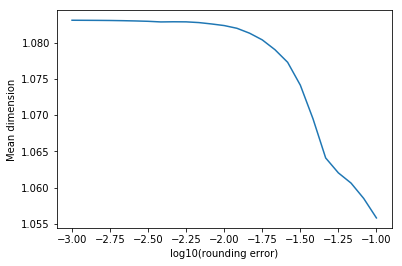

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

errors = 10**np.linspace(-1, -3, 25)
mean_dimensions = []
for eps in errors:
    mean_dimensions.append(tn.mean_dimension(tn.round(t, eps=eps)))
    
plt.figure()
plt.plot(np.log10(errors), mean_dimensions)
plt.xlabel('log10(rounding error)')
plt.ylabel('Mean dimension')
plt.show()

We can also compute the *restricted* mean dimension, i.e. impose certain conditions on the set of tuples that intervene. For example, we can see which of two variables tends to show up more with higher-order terms:

In [15]:
print(tn.mean_dimension(t, mask=x))
print(tn.mean_dimension(t, mask=y))

tensor(1.1355)
tensor(1.3664)


### The Dimension Distribution

Last, the [*dimension distribution*](http://www3.stat.sinica.edu.tw/statistica/oldpdf/A13n11.pdf) gathers the relevance of $k$-tuples of variables for each $k = 1, \dots, N$:

In [16]:
start = time.time()
dimdist = tn.dimension_distribution(t)
print(dimdist)
print('Time:', time.time() - start)

tensor([9.2223e-01, 7.2741e-02, 4.7444e-03, 2.6979e-04, 1.3797e-05, 6.4638e-07,
        2.8097e-08, 1.1428e-09, 4.3612e-11, 1.5722e-12, 5.3506e-14, 1.7216e-15,
        5.2287e-17, 1.4966e-18, 4.0144e-20, 1.0023e-21, 2.3034e-23, 4.7723e-25,
        8.6303e-27, 1.3940e-28])
Time: 0.11500120162963867


It can be viewed as a probability mass function, namely the probability of choosing a $k$-variable tuple, if tuples are chosen according to their variance components. The expected value of this random variable is the mean dimension. Naturally, the dimension distribution must sum to $1$:

In [17]:
sum(dimdist)

tensor(1.0000)

Again, we can extract the dimension distribution with respect to any mask:

In [18]:
tn.dimension_distribution(t, mask=y&z)

tensor([0.0000, 0.6815, 0.2870, 0.0293, 0.0021, 0.0001, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

We just imposed that two variables ($y$ and $z$) appear. Note how, accordingly, the relevance of $1$-tuples has become zero since they have all been discarded.